In [12]:
import cv2
import numpy as np
import pytesseract
from typing import Tuple, List, Dict
from PIL import Image
import pdf2image


def preprocess_digits(img_array: np.ndarray) -> np.ndarray:
    """
    Preprocess image array for better digit recognition
    
    Args:
        img_array: numpy array of the image
        
    Returns:
        processed numpy array ready for OCR
    """
    # Ensure array is in the right format
    if img_array.dtype != np.uint8:
        img_array = (img_array * 255).astype(np.uint8)
    
    # If image is not already grayscale, convert to grayscale
    if len(img_array.shape) == 3:
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_array.copy()
    
    # Remove yellow background using thresholding
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    
    # Optional: Remove noise
    kernel = np.ones((2,2), np.uint8)
    denoised = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Optional: Increase contrast
    enhanced = cv2.GaussianBlur(denoised, (3,3), 0)
    
    # Optional: Resize image (making it larger can help)
    scale_factor = 2
    enlarged = cv2.resize(enhanced, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    
    return enlarged

def extract_student_id(img_array: np.ndarray) -> str:
    """
    Improved student ID extraction with better OCR settings
    """
    processed_img = preprocess_digits(img_array)
    
    # Modified config for better recognition
    custom_config = r'--oem 3 --psm 13 -c tessedit_char_whitelist=0123456789 --dpi 300'
    
    student_id = pytesseract.image_to_string(
        processed_img,
        lang='eng',
        config=custom_config
    )
    
    # Clean up the result
    student_id = ''.join(filter(str.isdigit, student_id))
    
    # If we get no digits, try alternate PSM mode
    if not student_id:
        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789 --dpi 300'
        student_id = pytesseract.image_to_string(
            processed_img,
            lang='eng',
            config=custom_config
        )
        student_id = ''.join(filter(str.isdigit, student_id))
    
    return student_id

def preprocess_image(image_path: Image.Image) -> np.ndarray:
    """
    Preprocess the image for better text and checkbox detection.
    Takes a PIL Image from pdf2image as input.
    """
    # Convert PIL Image to numpy array
    img = np.array(image_path)
    
    # Convert RGB to BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to get binary image
    _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
    
    return binary

def extract_student_info(img: np.ndarray) -> Tuple[str, str]:
    """
    Extract student name and ID from the top portion of the form.
    """
    # Define regions for name and ID (you'll need to adjust these coordinates)
    name_roi = img[343:407, 273:628]
    id_roi = img[349:402, 1225:1549]
    
    # Extract text using pytesseract
    name = pytesseract.image_to_string(name_roi, lang='tha+eng')
    student_id = pytesseract.image_to_string(id_roi, lang='eng')
    
    # Clean up the extracted text
    name = name.strip()
    student_id = ''.join(filter(str.isdigit, student_id))
    
    return name, student_id

def detect_checkmarks(img: np.ndarray) -> List[Dict[str, int]]:
    """
    Detect checkmarks in the scoring columns and calculate scores.
    Returns a list of dictionaries containing scores for each item.
    """
    # Define the regions for scoring columns (adjust coordinates as needed)
    complete_column = img[150:850, 450:500]    # ครบถ้วน column
    incomplete_column = img[150:850, 500:550]  # ไม่ครบถ้วน column
    
    # Split into rows (one for each checklist item)
    row_height = 30  # Adjust based on form layout
    num_rows = 20    # Total number of checklist items
    
    scores = []
    for i in range(num_rows):
        row_start = i * row_height
        row_end = row_start + row_height
        
        # Check complete column
        complete_roi = complete_column[row_start:row_end, :]
        complete_pixel_sum = np.sum(complete_roi < 200)  # Dark pixels indicate marks
        
        # Check incomplete column
        incomplete_roi = incomplete_column[row_start:row_end, :]
        incomplete_pixel_sum = np.sum(incomplete_roi < 200)
        
        # Determine score (being lenient as requested)
        if complete_pixel_sum > 100:  # Threshold for detecting marks
            scores.append({'item': i + 1, 'score': 2})
        elif incomplete_pixel_sum > 100:
            scores.append({'item': i + 1, 'score': 1})
        else:
            scores.append({'item': i + 1, 'score': 2})  # Being lenient
            
    return scores

def analyze_cpr_checklist(image_path: str) -> Dict:
    """
    Main function to analyze the CPR checklist and return results.
    """
    # Preprocess the image
    processed_img = preprocess_image(image_path)
    
    # Extract student information
    name, student_id = extract_student_info(processed_img)
    
    # Detect checkmarks and calculate scores
    scores = detect_checkmarks(processed_img)
    
    # Calculate total score
    total_score = sum(item['score'] for item in scores)
    
    return {
        'student_name': name,
        'student_id': student_id,
        'individual_scores': scores,
        'total_score': total_score
    }



In [47]:
import cv2
import numpy as np
import pytesseract



In [ ]:
# Convert PIL Image to numpy array for OpenCV
image_array = np.array(image)

# Create a window and let user select ROI
roi = cv2.selectROI("Select Region", image_array)
x, y, w, h = roi

# Crop the selected region
region = image_array[y:y+h, x:x+w]

# Get text from selected region
text = pytesseract.image_to_string(region)

# Close all windows
cv2.destroyAllWindows()


In [ ]:
x, y, w, h

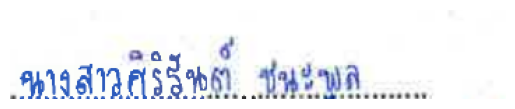

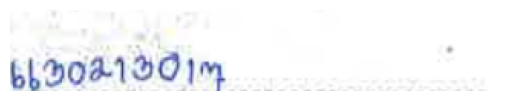

In [80]:
# Convert PIL Image to numpy array for OpenCV
from matplotlib import pyplot as plt
pdf_path = 'test.pdf'
image = pdf2image.convert_from_path(pdf_path)[15]
# image = preprocess_image(image)
result_image = np.array(image)
name_area = result_image[343:407, 273:628]
id_area = result_image[349:402, 1225:1549]
plt.imshow(name_area)
plt.axis('off')
plt.show()
plt.imshow(id_area)
plt.axis('off')
plt.show()

In [81]:
img = result_image
name_roi = img[343:407, 273:628]
id_roi = img[349:402, 1225:1549]

# Extract text using pytesseract
name = pytesseract.image_to_string(name_roi, lang='tha+eng')
student_id = pytesseract.image_to_string(id_roi, lang='eng', config='--psm 7 -c tessedit_char_whitelist=0123456789')

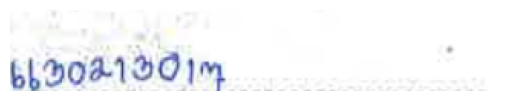

In [82]:
plt.imshow(id_roi)
plt.axis('off')
plt.show()


'0'

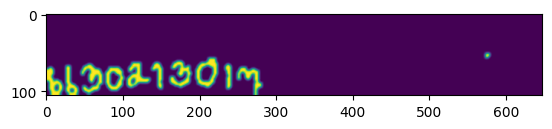

: 

In [84]:
processed_id_roi = preprocess_digits(id_roi)
extracted_id = extract_student_id(processed_id_roi)
plt.imshow(processed_id_roi)
extracted_id

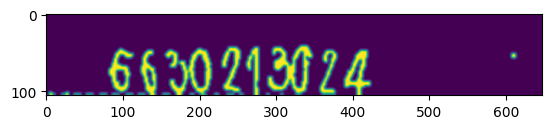

In [35]:
plt.imshow(processed_id_roi)

In [34]:
extracted_id

'4202174'

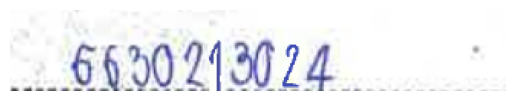

In [28]:
plt.imshow(id_roi)
plt.axis('off')
plt.show()

In [27]:
name, student_id

('wWadaal ad. Aaaeg\n', '')

In [31]:
preprocessed_image_path = preprocess_image(image_path)

NameError: name 'image_path' is not defined

In [ ]:
def main():
    # Example usage
    pdf_path = 'test.pdf'
    image_path = pdf2image.convert_from_path(pdf_path)[0]
    results = analyze_cpr_checklist(image_path)
    
    print(f"Student Name: {results['student_name']}")
    print(f"Student ID: {results['student_id']}")
    print(f"Total Score: {results['total_score']}")
    print("\nDetailed Scores:")
    for score in results['individual_scores']:
        print(f"Item {score['item']}: {score['score']} points")

if __name__ == "__main__":
    main()